In [1]:
import numpy as np
import qutip as qt
import scipy.stats as sp
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import random
from ipynb.fs.full.myfunctions import *
import itertools
import time

In [2]:
def sample_ginibre_ensemble(n, p, dim_n, dim_k=None):
    # draw n states from the ginibre distribution (unbiased)
    if dim_k is None: dim_kk = dim_n
    else: dim_kk = dim_k
    x_0 = np.zeros((n, dim_n**2))
    w_0 = np.ones(n)/n
    for i in range(n):
        dm = rand_dm_ginibre(dim_n, dim_kk)
        x_0[i] = dm_to_bvector(dm, p, dim_n) # calculate pauli representation
    return x_0, w_0

def experiment(rho, c):
    # measure rho pauli basises specified in c
    if(len(rho) != 4 ** len(c[0])): print("wrong dimensions!")
    q = len(c[0])
    data = np.zeros(c.shape)
    a = np.array([list(i) for i in itertools.product([0, 1], repeat=q)]) # possible measurement outcomes
    ind = np.array([4**i for i in range(q)][::-1])
    for idc, ci in enumerate(c):
        probs = np.zeros(len(a))
        for ida, ai in enumerate(a): # loop over possible outcomes
            for bi in a: # loop over all involved measurements
                probs[ida] += (-1)**(np.sum(bi*ai))*rho[int(np.sum(ci * ind * bi))]
        data[idc] = a[np.random.choice(range(len(a)), p = probs)]
    return data
    
def likelihood(x, d, c):
    # calculate likelihood of measurement outcome d given that the state is x
    lh = np.zeros(len(x))
    ind = np.array([4**i for i in range(len(c))][::-1])
    b = np.array([list(i) for i in itertools.product([0, 1], repeat=len(c))])
    for idx, xi in enumerate(x):
        for bi in b:
            lh[idx] += (-1)**(np.sum(bi*d))*xi[int(np.sum(c * ind * bi))]
    return lh

def bayes_update(x, w, d, c, n_active, threshold):
    # update weights according to likelihood and normalize
    w_temp = w
    start = time.time()
    for i in range(len(c)):
        w_new = np.zeros(len(w_temp))
        w_new[n_active] = w_temp[n_active] * likelihood(x[n_active], d[i], c[i])
        w_new[n_active] = np.divide(w_new[n_active], np.sum(w_new[n_active]))
        w_temp = w_new
        n_active = n_active[np.where(w_temp[n_active] > threshold)]
    end = time.time()
    return w_temp, end-start

def pointestimate(x, w):
    # return point estimate of rho
    return np.average(x, axis=0, weights= w)

def fidelity(a, b, p):
    # compute fidelity from density matrices in Pauli representation
    return qt.metrics.fidelity(bvector_to_dm(a, p), bvector_to_dm(b, p))**2

In [ ]:
n_q = 2 # number of Qubits - fixed in this implementation
dim = 2**n_q # dimension of Hilbert space
p = create_pauli_basis(n_q) # create Pauli basis

# experiment in Pauli basis
n_meas = 1000 # number of measurements
c_meas = np.random.randint(1, 4, size= (n_meas, n_q)) # create pauli measurement basis (1=x, 2=y, 3=z)

# sampling
n = 100 # number of sampling points

# cut_off
threshold = 1 / (n**2)
n_active0 = np.arange(n)

In [ ]:
x, w0 = sample_ginibre_ensemble(n, p, dim, dim) # Generate particle cloud unbiased prior
rho = x[0] # Ideal state
d_meas = experiment(rho, c_meas) # Experiments
print(d_meas)

In [ ]:
# Update the weights of the point cloud
w, dt = bayes_update(x, w0, d_meas, c_meas, n_active0, threshold)

In [ ]:
# Estimates
rho_est = pointestimate(x, w)
print(fidelity(rho, rho_est, p))
print(dt)

In [3]:
### CONVERGENCE ###

n_q = 2 # number of Qubits - fixed in this implementation
dim = 2**n_q # dimension of Hilbert space
p = create_pauli_basis(n_q) # create Pauli basis

# experiment in Pauli basis
n_meas = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1028] # number of measurements
meas_rep = 8 # number of repetition
c_meas = np.random.randint(1, 4, size= (meas_rep, n_meas[-1], n_q)) # create pauli measurement basis (1=x, 2=y, 3=z)

# sampling number
n = 10000
rep_prep = 16

# cut off
threshold = 1 / n**3
n_active0 = np.arange(n)

# output
fid = np.zeros((len(n_meas), rep_prep, meas_rep))
t = np.zeros((len(n_meas), rep_prep, meas_rep))
n_ess = np.zeros((len(n_meas), rep_prep, meas_rep))
w_rho = np.zeros((len(n_meas), rep_prep, meas_rep))

In [4]:
for i in range(rep_prep):
    if i%4 == 0: print(i)
    x, w0 = sample_ginibre_ensemble(n, p, dim, dim)
    rho = x[0] # Ideal state
    for j in range(meas_rep):
        d_meas = experiment(rho, c_meas[j]) # Experiments
        for idk, k in enumerate(n_meas):
            w, dt = bayes_update(x, w0, d_meas[:k], c_meas[j][:k], n_active0, threshold)
            fid[idk][i][j] = np.round(fidelity(rho, pointestimate(x, w), p), decimals= 7)
            t[idk][i][j] = np.round(dt, decimals= 3)
            n_ess[idk][i][j] = np.round(1 / np.sum(w**2), decimals= 4)
            w_rho[idk][i][j] = np.round(w[0], decimals= 4)

0
4
8
12


In [6]:
np.save("fid0604", fid)
np.save("ness0604", n_ess)
np.save("t0604", t)
np.save("w0604", w_rho)

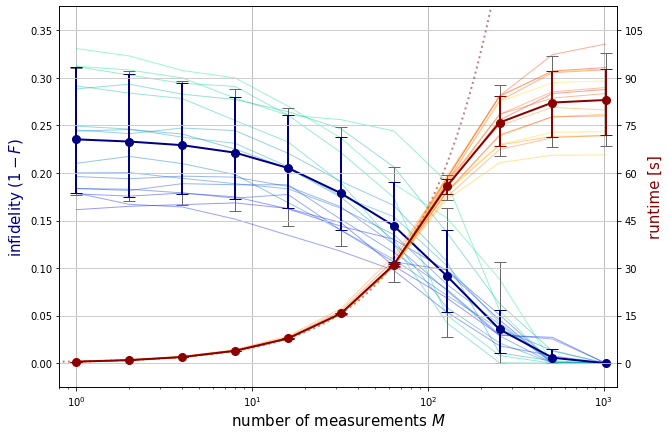

In [279]:
tt = np.concatenate((t[:, 0:13, :], t[:, 14:, :]), axis=1)

fid_avg = np.average(1 - fid, axis=(1, 2))
fid_8_total = [fid_avg - np.percentile(1 - fid, 87.5, axis=(1, 2)), np.percentile(1 - fid, 12.5, axis=(1, 2)) - fid_avg]
fid_8_prep = [fid_avg - np.percentile(np.average(1 - fid, axis=2), 87.5, axis= 1), np.percentile(np.average(1 - fid, axis=2), 12.5, axis=1) - fid_avg]

t_avg = np.average(tt, axis=(1, 2))
t_8_total = [t_avg - np.percentile(tt, 87.5, axis=(1, 2)), np.percentile(tt, 12.5, axis=(1, 2)) - t_avg]
t_8_prep = [t_avg - np.percentile(np.average(tt, axis=2), 87.5, axis= 1), np.percentile(np.average(tt, axis=2), 12.5, axis=1) - t_avg]

# Plot fidelities
fig, ax1 = plt.subplots(figsize=(10, 7))
ax2 = ax1.twinx()

m_s = 8
cmap = plt.get_cmap('winter')
c_ind = np.argsort(np.average(1 - fid[0, :, :], axis=1))                         
for c_i, i in enumerate(c_ind):
    ax1.plot(n_meas, np.average(1 - fid[:, i, :], axis=1),  c= cmap(c_i /len(fid[1])), ls='-', marker='o', ms= 0, lw= 1, alpha=0.4)    
ax1.errorbar(n_meas, fid_avg, yerr= fid_8_total, ls='-', ms= 0, c= 'dimgrey', lw= 0, capsize=6, elinewidth=1)
ax1.errorbar(n_meas, fid_avg, yerr= fid_8_prep, ls='-', marker='o', ms= m_s, c='navy', lw= 2, capsize=6, elinewidth=2)
#ax1.errorbar(n_meas, fid_avg, yerr= fid_8_total, marker='o', ms= m_s, c= 'navy', lw= 0, capsize=0, elinewidth=0)

m_s = 8
cmap = plt.get_cmap('autumn')

coef = np.polyfit(n_meas[:6], np.average(tt[:6], axis=(1,2)), 1)[0] 
x_t = np.linspace(0, n_meas[-1], 1000)
ax2.plot(x_t, coef * x_t, ls=':', c='darkred', lw= 2, alpha= 0.5)

for c_i, i in enumerate(c_ind):
    if i!= 13: ax2.plot(n_meas, np.average(t[:, i, :], axis=1),  c= cmap(c_i /len(fid[1])), ls='-', marker='o', ms= 0, lw= 1, alpha=0.4)    
ax2.errorbar(n_meas, t_avg, yerr= t_8_total, ls='-', ms= 0, c= 'dimgrey', lw= 0, capsize=6, elinewidth=1)
ax2.errorbar(n_meas, t_avg, yerr= t_8_prep, ls='-', marker='o', ms= m_s, c='darkred', lw= 2, capsize=6, elinewidth=2)
#ax2.errorbar(n_meas, t_avg, yerr= t_8_total, marker='o', ms= m_s, c= 'darkred', lw= 0, capsize=0, elinewidth=0)

fs = 15
ax1.set_xscale('log', base=10)
ax1.set_xlim(0.8, 1200)
ax1.set_xlabel(r'number of measurements $M$', fontsize=fs)
ax1.set_xticks([1, 10, 100, 1000], fontsize=fs)
ax1.set_ylabel(r'infidelity ($1-F$)', fontsize=fs, c= 'navy')
ax1.set_yticks(np.linspace(0, 0.35, 8), fontsize=fs)
ax1.set_ylim(-0.025, 0.375)
ax1.grid()

ax2.set_ylabel(r'runtime [s]', fontsize=fs, c= 'darkred')
ax2.set_yticks(np.linspace(0, 105, 8), fontsize=fs)
ax2.set_ylim(-7.5, 112.5)

plt.grid(c='lightgray')
plt.show()

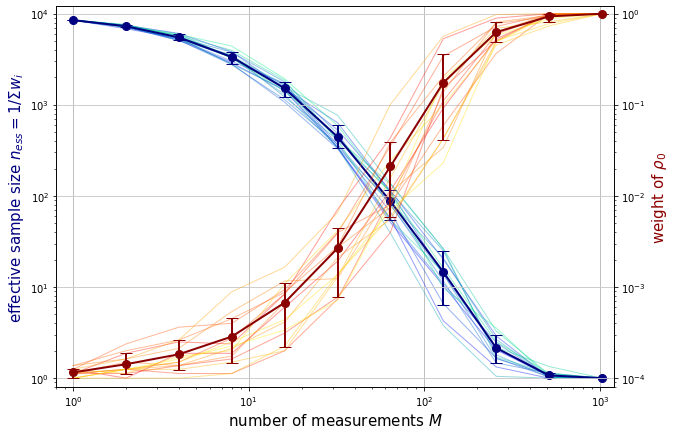

In [275]:
n_ess_avg = np.average(n_ess, axis=(1, 2))
n_ess_8_total = [n_ess_avg - np.percentile(n_ess, 87.5, axis=(1, 2)), np.percentile(n_ess, 12.5, axis=(1, 2)) - n_ess_avg]
n_ess_8_prep = [n_ess_avg - np.percentile(np.average(n_ess, axis=2), 87.5, axis= 1), np.percentile(np.average(n_ess, axis=2), 12.5, axis=1) - n_ess_avg]

w_avg = np.average(w_rho, axis=(1, 2))
w_8_total = [w_avg - np.percentile(w_rho, 87.5, axis=(1, 2)), np.percentile(w_rho, 12.5, axis=(1, 2)) - w_avg]
w_8_prep = [w_avg - np.percentile(np.average(w_rho, axis=2), 87.5, axis= 1), np.percentile(np.average(w_rho, axis=2), 12.5, axis=1) - w_avg]

# Plot n_esselities
fig, ax1 = plt.subplots(figsize=(10, 7))
ax2 = ax1.twinx()

m_s = 8
cmap = plt.get_cmap('winter')
c_ind = np.argsort(np.average(n_ess[0, :, :], axis=1))                         
for c_i, i in enumerate(c_ind):
    ax1.plot(n_meas, np.average(n_ess[:, i, :], axis=1),  c= cmap(c_i /len(n_ess[1])), ls='-', marker='o', ms= 0, lw= 1, alpha=0.4)    
ax1.errorbar(n_meas, n_ess_avg, yerr= n_ess_8_prep, ls='-', marker='o', ms= m_s, c='navy', lw= 2, capsize=6, elinewidth=2)
#ax1.errorbar(n_meas, n_ess_avg, yerr= n_ess_8_total, marker='o', ms= m_s, c= 'navy', lw= 0, capsize=0, elinewidth=0)

m_s = 8
cmap = plt.get_cmap('autumn')

for c_i, i in enumerate(c_ind):
    ax2.plot(n_meas, np.average(w_rho[:, i, :], axis=1),  c= cmap(c_i /len(n_ess[1])), ls='-', marker='o', ms= 0, lw= 1, alpha=0.4)    
ax2.errorbar(n_meas, w_avg, yerr= w_8_prep, ls='-', marker='o', ms= m_s, c='darkred', lw= 2, capsize=6, elinewidth=2)
#ax2.errorbar(n_meas, t_avg, yerr= t_8_total, marker='o', ms= m_s, c= 'darkred', lw= 0, capsize=0, elinewidth=0)

fs = 15
ax1.set_xscale('log', base=10)
ax1.set_yscale('log', base=10)
ax1.set_xlim(0.8, 1200)
ax1.set_xlabel(r'number of measurements $M$', fontsize=fs)
ax1.set_xticks([1, 10, 100, 1000], fontsize=fs)
ax1.set_ylabel(r'effective sample size $n_{ess} = 1 / \Sigma w_i$', fontsize=fs, c= 'navy')
ax1.set_yticks([1, 10, 100, 1000, 10000], fontsize=fs)
ax1.set_ylim(0.8, 12000)
ax1.grid()

ax2.set_ylabel(r'weight of $\rho_0$', fontsize=fs, c= 'darkred')
ax2.set_yticks(np.linspace(0, 1, 8), fontsize=fs)
ax2.set_yscale('log', base=10)
ax2.set_ylim(0.00008, 1.2)

plt.grid(c='lightgray')
plt.show()
